In [159]:
import numpy as np
import matplotlib.pyplot as plt

In [160]:
#we need to read the file
#../input_data/trajNaCl.pdb
#500 timeframes

#bash command to filter
#grep ATOM trajNaCl.pdb | tr -s ' ' | cut -d' ' -f6-8 > filter_trajNaCl.txt

In [161]:
def data_init():
    data = np.loadtxt("../input_data/filter_trajNaCl.txt") #500 blocks of 40 lines
    cell = 31.47
    bins = 7 #total number of bins, also affects the amount of values g gets
    ngr = 0 # what is ngr for ?
    delg = cell/(2*bins) #delg is bin size
    g = np.zeros(bins) 
    #First chunk over
    npart = 40 #amount of particles
    return data, cell, bins, ngr, delg, g, npart

In [162]:
#I have to figure out how the periodic conditions are given, is box a vector or not?
def rdf(g, ngr, cell, data, delg, npart):
    for k in range(0, 500, npart): #k for the different timeframes
        ngr = ngr + 1 #should be the right place for ngr, it seems to count timeframes?
        #the actual pairing
        #do it seperately for Na-Na, Na-Cl, Cl-Cl? Seems all at once is the right way
        for i in range(k+0, k+npart-1):
            for j in range(k+1, k+npart):
                #distance between a particle pair
                r = data[i]-data[j]
                #implement periodic boundary conditions
                r = r - cell*np.round(r/cell)
                r = np.linalg.norm(r)
                #half-box check & contribution
                if r <= cell/2: #this needs to be true in all fields to proceed right?
                    l = int(r/delg) #ok so l has to be a scalar, but r is a vector and delg as well...
                    g[l] = g[l] + 2
    return g, ngr

In [163]:
def grdf(g, ngr, bins, cell):
    #rho = 20/cell**3 #That would be the density? It really doesn't seem to change much for the graph
    #So far the problems seems to be the normalization of g(r)
    rho = 1
    r = [] 
    for i in range(0, bins):
        r.append(delg*(i+0.5))  #So this will by the x-axis
        vol = ((i+1)**3  - i**3 )*delg**3 
        nid = (4/3)*np.pi*vol*rho  
        #vol and nid, seem a bit weird to me
        g[i] = g[i]/(ngr*npart*nid)  
        #This is the normalization part, I need a a proper value for rho
    return g, r

In [164]:
data, cell, bins, ngr, delg, g, npart = data_init()
g, ngr = rdf(g, ngr, cell, data, delg, npart)
g, r = grdf(g, ngr, bins, cell)

In [165]:
print("length of g:", np.size(g))
print("values of g:", g)

length of g: 7
values of g: [0.03993548 0.00118952 0.00289751 0.00239683 0.00230066 0.00245899
 0.00237749]


(0.0, 0.039935476431418496)

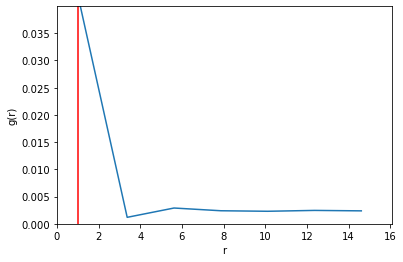

In [166]:
plt.plot(r, g)
plt.xlabel('r')
plt.vlines(1, 0, 2*np.max(g), colors="red")
plt.ylabel('g(r)')
plt.xlim( (0, np.max(r)*1.1) )
plt.ylim( (0, np.max(g)) )